In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import time
import os
import scipy
from scipy import optimize
from sklearn.cluster import KMeans
from scipy import special

In [ ]:
## if the 'tuning' package is intalled, run this cell. (needs python3 installed)

## Otherwise, go to the bottom of this notebook and run the function definitions in "tool functions". (only needs python2).

# from tuning.cyMINoncyclic import mc_mean_grad_gaussian, mc_mean_grad_gaussian_inhomo # gaussian models
# from tuning.cyMINoncyclic import mc_coeff_arimoto_gaussian, mc_coeff_arimoto_gaussian_inhomo # gaussian models
from tuning.repulsive_model import tuning_update_inhomo, conditional_probability_matrix_gaussian
from tuning.repulsive_model import evaluate_elastic_term, mutual_distance
from tuning.functions_for_analysis import gen_binary_hierachical_curves
from tuning.anim_3dcube import pc_fun_weights, plot_funcs_in_figure
# for 3d illustration:
# from tuning.anim_3dcube import create_figure_canvas, set_data_in_figure, get_color_array, gen_mixed_plots, gen_mixed_anim


<IPython.core.display.Javascript object>


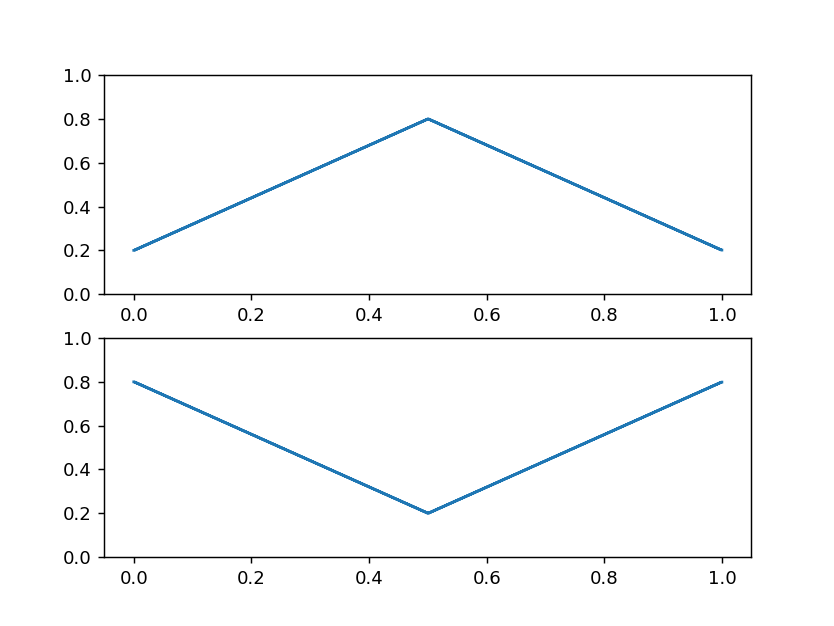

In [8]:
# # ----------initialization---------  
numNeuro = 2

numBin = 1020 

num_periods = 1
bn_tc = np.array([0.2, 0.8]*num_periods) # repetations of [0, 1, 0, 1, ...]
len_v = int(numBin/(2*num_periods))
vec = np.linspace(0, 1, len_v + 1)[:len_v]

tuning = np.zeros((numNeuro, numBin))
for k in range(len(bn_tc)):
    tuning[0, k*len_v:(k+1)*len_v] = bn_tc[k] + vec*(bn_tc[(k+1)%len(bn_tc)] - bn_tc[k])
    
len_shift = int(numBin/numNeuro)
for i in range(numNeuro):
    tuning[i,:] = np.roll(tuning[0,:], len_shift*i)



weight = 1.0*np.ones(numBin)/numBin

fig = plt.figure()
_ = plot_funcs_in_figure(fig, tuning, weight, nrow=numNeuro, ncol=1, fp = 1, fm = 0)

In [9]:
# # ----------optimization function, derivative, bounds, constraint---------  
# added self energy term
def opt_fun(w, A, gamma):
    return np.dot(w, (np.dot(A, w))) + gamma*np.sum(w**2)
            
def grad_fun(w, A, gamma):
    return np.dot(A + np.transpose(A), w) + 2*gamma*w

weight_bounds = []
for j in range(len(weight)): # number of bins
    weight_bounds += [(0, 1)]
weight_bounds = tuple(weight_bounds)

my_cons = [{'type':'eq', 'fun': lambda w: (np.sum(w) - 1)}]

# # ----------parameters of the Gaussian model---------
sigma= 0.2
sigma_vec = np.array([sigma]*len(weight))

alpha = 3
gamma = 0



In [10]:
# # ---------initialization of results-saving-------
tuning_list = [tuning.copy()]
weight_list = [weight.copy()]

opt_list = []
info_list = []
EVALUATE_OPT = True
EVALUATE_EL = True
EVALUATE_MI = False
eta_list = [None]
beta_list = [None]
Lambda_list = [None]
elastic_term_list = [None]
elastic_value_list = [None]
gamma_list = [gamma]

tuning = tuning_list[0].copy()

if EVALUATE_OPT:
    P = conditional_probability_matrix_gaussian(tuning, sigma_vec, alpha = alpha)
    opt_list += [opt_fun(weight, P, gamma)]
    print(opt_list)


[2.2537804806338437]


<IPython.core.display.Javascript object>


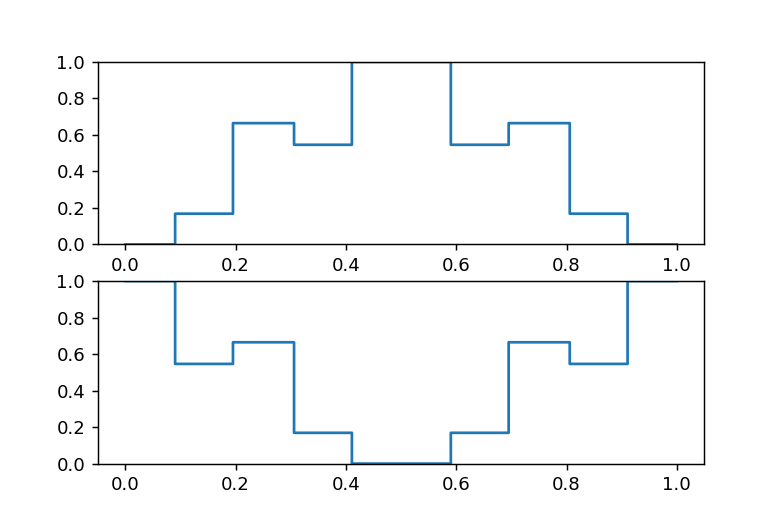

num_iter=100, opt = 1.01


In [16]:
# #--------start iterations-----------
ncol = 1
nrow = numNeuro
T = 100

eta = 10 # learning rate for Gradient Descent
beta = 0#5e-3 # elasticity

elastic_term = 'exp'
Lambda = 0.2

ALTER_WEIGHT = T+1

EVALUATE_OPT = True
EVALUATE_EL = True
EVALUATE_MI = False
PLOT = True
ALTER_PLOT = 10

fp = 1; fm = 0

if PLOT:
    %matplotlib notebook

    fig = plt.figure(figsize = (ncol*6, nrow*2))
    ax_list = []
    for i in range(numNeuro):
        ax = fig.add_subplot(nrow,ncol,i+1)
        ax_list.append(ax)

    for i in range(numNeuro):
        xx, yy = pc_fun_weights(tuning[i,:], weight)
        ax_list[i].plot(xx, yy)
        ax_list[i].set_ylim([fm, fp])
    #     ax_list[i].scatter(np.arange(numBin), tuning[i, :])

    fig.canvas.draw()

        
for num_iter in range(1, T+1):
    
    tuning_new = tuning_update_inhomo(
        tuning, weight, sigma_vec, alpha = alpha,
        eta = eta, beta = beta, Lambda = Lambda, elastic_term = elastic_term,
    )
    
    tuning = tuning_new.copy()

    
    if num_iter % ALTER_WEIGHT ==0:        
        D = conditional_probability_matrix_gaussian(tuning, sigma_vec, alpha=alpha)
        disp = False
        ftol = 1e-6
        res = optimize.minimize(opt_fun, weight, args = (D,gamma), \
                                method='SLSQP', jac = grad_fun, \
                                bounds = weight_bounds, constraints = my_cons, \
                                options = {'maxiter':WEIGHT_ITER_NUM, 'ftol': ftol, 'disp': disp})

        weight_new = res['x'].copy()
        print(res['fun'], opt_fun(weight, D, gamma))
        #print(weight_new)
        weight = weight_new.copy()
        
    tuning_list += [tuning.copy()]
    weight_list += [weight.copy()]
    
    eta_list += [eta]
    beta_list += [beta]
    Lambda_list += [elastic_term]
    elastic_term_list += [Lambda]
    gamma_list += [gamma]
    
    if EVALUATE_OPT:
        D = conditional_probability_matrix_gaussian(tuning, sigma_vec, alpha=alpha)   
        opt_list += [opt_fun(weight, D, gamma)]     
    if EVALUATE_EL:
        elastic_value_list += [
            evaluate_elastic_term(tuning, weight, alpha = alpha, 
                                           beta = beta, Lambda=Lambda, 
                                           elastic_term = elastic_term,
                                           elastic_term_periodic = True,
                                          )]

#     if EVALUATE_MI:
#         grad_tc = np.zeros_like(tuning)       
#         info_tc = mc_mean_grad_gaussian_inhomo(
#             grad_tc, tuning, weight,
#             inv_cov_matrix, conv, tau, int(1e4), my_num_threads = NUM_THREADS)
#         info_list += [info_tc/np.log(2)]

    if PLOT and num_iter%ALTER_PLOT==0:
        for i in range(numNeuro):
            ax_list[i].clear()
            xx, yy = pc_fun_weights(tuning[i,:], weight)
            ax_list[i].plot(xx, yy)
            ax_list[i].set_ylim([fm, fp])
#         time.sleep(0.1)
        fig.canvas.draw()
    if num_iter%100 == 0:
        print('num_iter=%d, opt = %.2f'%(num_iter, opt_list[-1]))
        



<IPython.core.display.Javascript object>


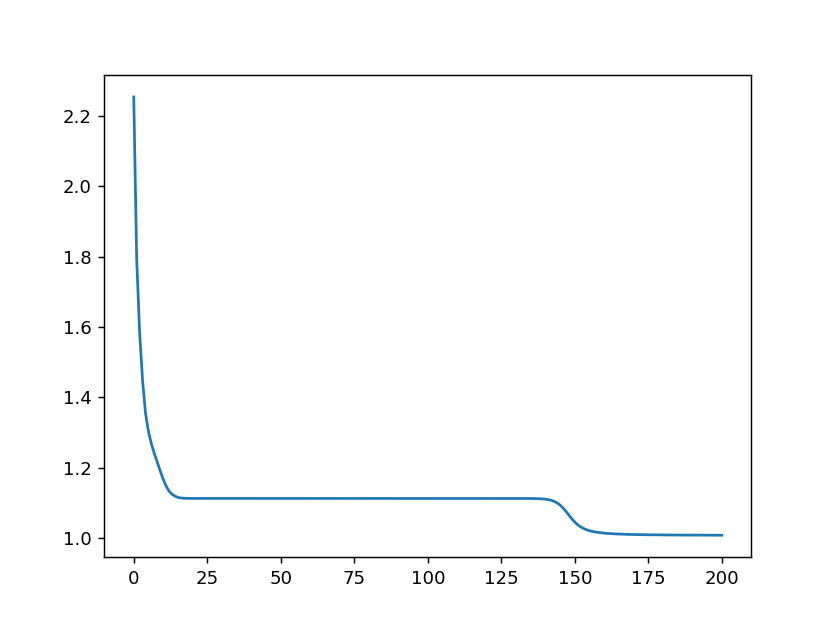

<IPython.core.display.Javascript object>


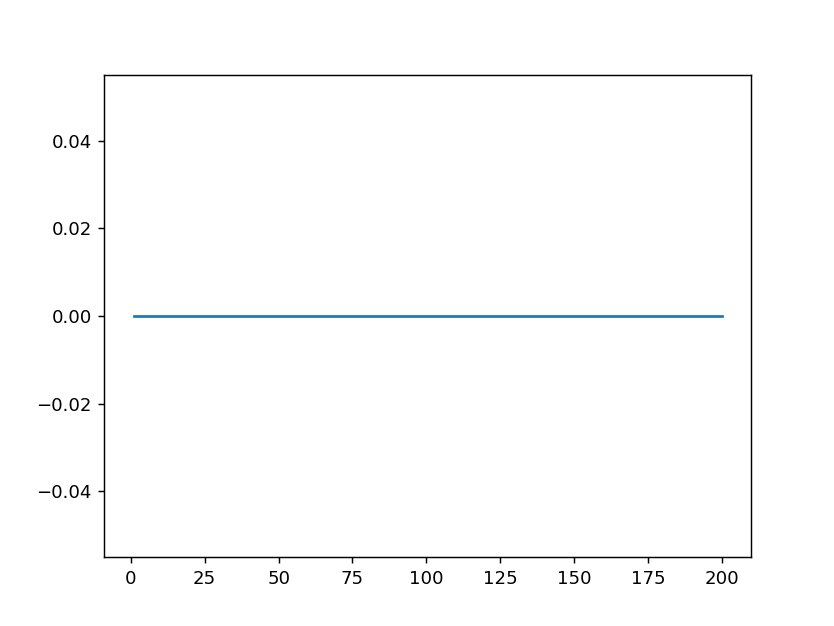

<IPython.core.display.Javascript object>


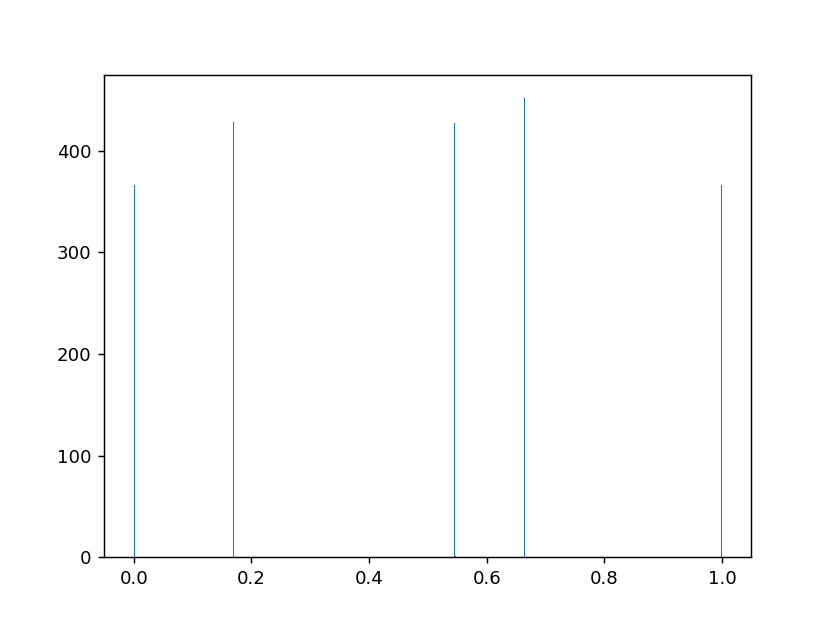

<IPython.core.display.Javascript object>


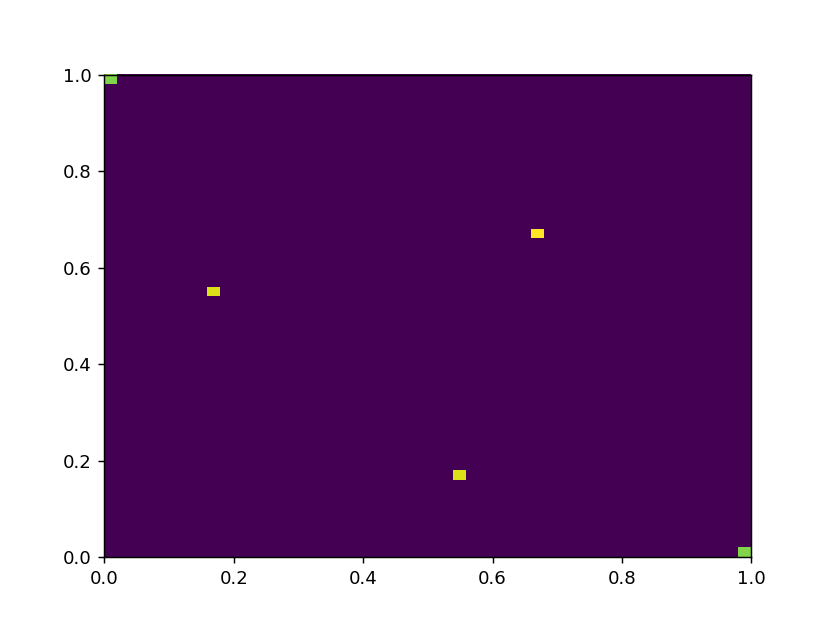

In [17]:
# #-------showing and saving results----------
plt.figure()
plt.plot(opt_list)

plt.figure()
plt.plot(elastic_value_list)


plt.figure()
_ = plt.hist(tuning.reshape(-1), bins = 500)

plt.figure()
_ = plt.hist2d(tuning[0,:], tuning[1,:], bins = 50)




<IPython.core.display.Javascript object>


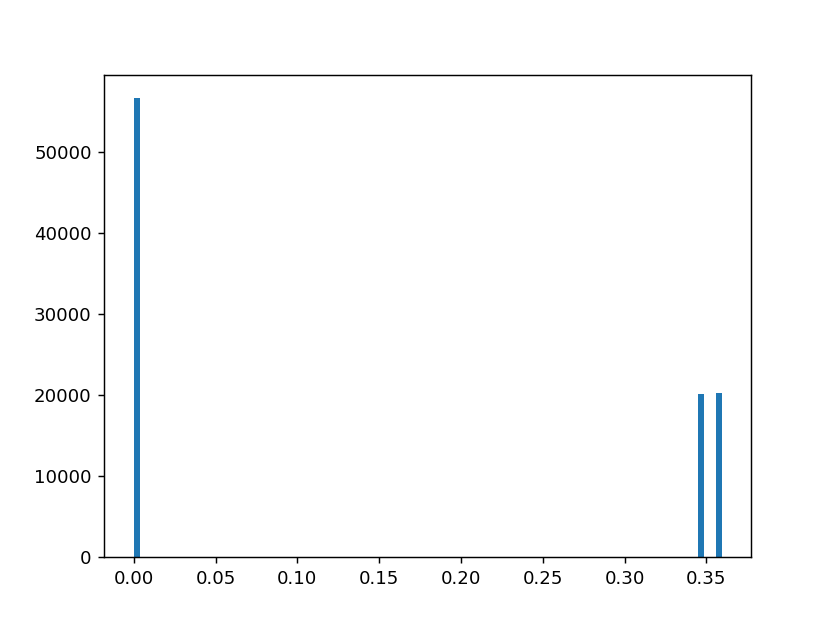

In [14]:
#--histograms of distances----

tc = tuning_list[-1]
dS = mutual_distance(tc)

num_neighbours = 100
dist_list = []
for i in range(1, num_neighbours+1):
    dist_list += list(np.diagonal(dS, offset = i))

plt.figure()
_ = plt.hist(dist_list, bins = 100)


In [15]:


FILE_NAME = "gauss_new/dim=%d_sigma=%.2f_alpha=%.2f_beta=%.1e_"%(
    numNeuro, sigma_vec[0],alpha, beta) + time.strftime("%m%d-%H%M%S")

res_dict = {}
res_dict['sigma'] = sigma_vec
res_dict['alpha'] = alpha

res_dict['eta'] = eta_list
res_dict['beta'] = beta_list
res_dict['gamma'] = gamma_list
res_dict['Lambda'] = Lambda_list
res_dict['elastic_term'] = elastic_term_list

res_dict['tuning'] = tuning_list
res_dict['weight'] = weight_list

res_dict['opt'] = opt_list
res_dict['info'] = info_list
res_dict['elastic'] = elastic_value_list

print(FILE_NAME)
np.save(FILE_NAME, res_dict)





gauss_new/dim=2_sigma=0.20_alpha=3.00_beta=0.0e+00_0603-171035


In [ ]:
# fig = plt.figure()
# ax_list = plot_funcs_in_figure(fig, tuning, weight, ncol = 1, nrow = numNeuro, fp = 1, fm = 0)
# ax_list[0].set_title(r'$\sigma = %.1f, \alpha = %.1f, \beta = %.1e$, F(x,w) = %.4f'%(sigma_vec[0], alpha, beta, opt_list[-1]))
# plt.savefig(FILE_NAME+'.jpg')

# fig = plt.figure()
# ax_list = plot_funcs_in_figure(fig, tuning_list[0], weight_list[0], ncol = 1, nrow = numNeuro, fp = 1, fm = 0)
# ax_list[0].set_title(r'$\sigma = %.1f, \alpha = %.1f, \beta = %.1e$, F(x,w) = %.4f'%(sigma_vec[0], alpha, beta, opt_list[0]))
# plt.savefig(FILE_NAME+'_initial.jpg')


# from mpl_toolkits.mplot3d import Axes3D
# if numNeuro ==2 :
#     plt.figure()
#     plt.scatter(tuning[0,:], tuning[1,:])
#     if beta != 0:
#         plt.plot(tuning[0, :], tuning[1, :], '--r', linewidth = 0.5)
#     plt.xlim([-0.01, 1.01])
#     plt.ylim([-0.01, 1.01])
#     plt.savefig(FILE_NAME+'_points.jpg')
# elif numNeuro == 3:
#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')
#     ax.scatter(tuning[0,:], tuning[1,:], tuning[2,:])
#     if beta != 0:
#         ax.plot(tuning[0, :], tuning[1, :], tuning[2, :], '--r', linewidth = 0.5)

#     ax.set_xlabel('x0')
#     ax.set_ylabel('x1')
#     ax.set_zlabel('x2')
#     ax.set_xlim([0, 1])
#     ax.set_ylim([0, 1])
#     ax.set_zlim([0, 1])

#     ax.set_title(r'$\sigma = %.1f, \alpha = %.1f, \beta = %.1f$, F(x,w) = %.4f'%(sigma_vec[0], alpha, beta, opt_list[-1]))
#     plt.show()
#     plt.savefig(FILE_NAME+'_points.jpg')



In [ ]:
# #-------loading results----------
# FILE_NAME = ""

# res_dict = np.load(FILE_NAME+'.npy', allow_pickle=True, encoding = 'latin1').item()


# fig = plt.figure()
# ax_list = plot_funcs_in_figure(fig, res_dict['tuning'][-1], res_dict['weight'][-1], 
#                                ncol = 1, nrow = res_dict['tuning'][-1].shape[0], fp = 1, fm = 0)
# ax_list[0].set_title(r'$\sigma = %.1f, \alpha = %.1f, \beta = %.1e$, F(x,w) = %.4f'%(
#     res_dict['sigma'][0], res_dict['alpha'], res_dict['beta'][-1], res_dict['opt'][-1]))
# plt.savefig(FILE_NAME+'.jpg')

# fig = plt.figure()
# ax_list = plot_funcs_in_figure(fig, res_dict['tuning'][0], res_dict['weight'][0],  
#                                ncol = 1, nrow = res_dict['tuning'][0].shape[0], fp = 1, fm = 0)
# ax_list[0].set_title(r'$\sigma = %.1f, \alpha = %.1f, \beta = %.1e$, F(x,w) = %.4f'%(
#     res_dict['sigma'][0], res_dict['alpha'], res_dict['beta'][-1], res_dict['opt'][0]))
# plt.savefig(FILE_NAME+'_initial.jpg')

# tuning = res_dict['tuning'][-1].copy()
# from mpl_toolkits.mplot3d import Axes3D
# if numNeuro ==2 :
#     plt.figure()
#     plt.scatter(tuning[0,:], tuning[1,:])
#     if beta != 0:
#         plt.plot(tuning[0, :], tuning[1, :], '--r', linewidth = 0.5)
#     plt.xlim([-0.01, 1.01])
#     plt.ylim([-0.01, 1.01])
#     plt.savefig(FILE_NAME+'_points.jpg')
# elif numNeuro == 3:
#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')
#     ax.scatter(tuning[0,:], tuning[1,:], tuning[2,:])
#     if beta != 0:
#         ax.plot(tuning[0, :], tuning[1, :], tuning[2, :], '--r', linewidth = 0.5)

#     ax.set_xlabel('x0')
#     ax.set_ylabel('x1')
#     ax.set_zlabel('x2')
#     ax.set_xlim([0, 1])
#     ax.set_ylim([0, 1])
#     ax.set_zlim([0, 1])

#     ax.set_title(r'$\sigma = %.1f, \alpha = %.1f, \beta = %.1f$, F(x,w) = %.4f'%(
#         res_dict['sigma'][0], res_dict['alpha'], res_dict['beta'][-1], res_dict['opt'][-1]))
#     plt.show()
#     plt.savefig(FILE_NAME+'_points.jpg')

In [ ]:
## ------clustering------

# from sklearn.cluster import KMeans

# num_clusters = 100
# kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(tuning.T)
# # kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(tuning_list[1000].T)

# tuning_new = kmeans.cluster_centers_.T

# weight_new = np.zeros(num_clusters)
# for i in range(num_clusters):
#     weight_new[i] = np.sum(weight[kmeans.labels_ == i])
# print(weight_new)
# print(np.sum(weight_new))

# fig = plt.figure()
# _ = plot_funcs_in_figure(fig, tuning_new, weight_new, ncol = 1, nrow = numNeuro, fp = 1, fm = 0)

## tool functions

In [ ]:
def tuning_update_inhomo(tuning, weight, sigma_vec, alpha = 2, eta = 1, beta = 0, Lambda = 1,
                         elastic_term = 'sum',# other options: 'exp', 'expweight', 'rand'
                         elastic_term_periodic = True, # use closed curve
                         upper_bound = 1, lower_bound = 0):
    '''Gaussian Model, no periodic boundary condition
    '''
    # tuning.shape = (numNeuro, numBin)
    # weight: vector, sum =1, length = numBin
    # sigma_vec: vector, gaussian std, length = numBin
    # Lambda: number, std for the laplacian term
    # eta: number, coefficient of the repulsive term
    # alpha: number, exponent of \|x_k - x_l\| in the probability distribution
    # beta: number, coefficient of the laplacian term
    nNeuro, nBin = tuning.shape
    dS = np.zeros((nBin, nBin))
    for i in range(nNeuro):
        dX = tuning[i,:][None, :] - tuning[i,:][:, None] # dX[k, l]=tuning[i, l]-tuning[i, k]
        dS += dX**2
    dS = np.sqrt(dS)
    # dS[k,l]: euclidean distance between the k-th point and the l-th point    

    
    # negative derivatives
    u = np.zeros((nNeuro, nBin))
    F = (dS**(alpha-2))*np.exp(-dS**alpha/(2*sigma_vec[:,None]**alpha))/sigma_vec[:,None]**(alpha+1)
    F2 = (dS**(alpha-2))*np.exp(-dS**alpha/(2*sigma_vec[None,:]**alpha))/sigma_vec[None, :]**(alpha+1)
    for i in range(nNeuro):
        xi = tuning[i,:]
        dX = xi[None, :] - xi[:, None]
        u[i,:] = np.sum(weight[:,None]*dX*F,axis = 0)
        
        # inside the sum:
        # [k,l] = weight[k]*dX[k,l]*(dS[k,l]**(alpha-2))
        # *np.exp(-dS[k,l]**alpha/(2*sigma_vec[k]**alpha))/sigma_vec[k]**(alpha+1)
        # = weight[k]*(x[l]_i-x[k]_i)*(dS[k,l]**(alpha-2))
        # *np.exp(-dS[k,l]**alpha/(2*sigma_vec[k]**alpha))/sigma_vec[k]**(alpha+1)
        # dS[k,l] = dS[l,k]
        # sum over k for fixed l
        u[i,:] += np.sum(weight[:,None]*dX*F2, axis = 0)
          
        # inside the sum:
        # [k,l] = weight[k]*dX[k,l]*(dS[k,l]**(alpha-2))
        # *np.exp(-dS[k,l]**alpha/(2*sigma_vec[l]**alpha))/sigma_vec[l]**(alpha+1)
        # = weight[k]*(x1[l]_i-x1[k]_i)*(dS[k,l]**(alpha-2))
        # *np.exp(-dS[k,l]**alpha/(2*sigma_vec[l]**alpha))/sigma_vec[l]**(alpha+1)
        # sum over k for fixed l        
    u = weight*alpha*0.5*u # u[i,k] = weight[k]*u[i,k]*alpha*0.5
 
    # positive derivatives of the elastic term
    dl = np.zeros((nNeuro, nBin))
    
    if beta != 0:
        
        diffx = np.zeros((nNeuro, nBin))        
        diffx[:, 0:-1] = np.diff(tuning, axis = 1) # x[k+1]_i - x[k]_i
        if elastic_term_periodic:
            diffx[:, -1] = tuning[:, 0] - tuning[:, -1]
            
        revdiffx =-np.roll(diffx, 1, axis = 1) # x[k-1]_i - x[k]_i
        
        diffS = np.sqrt(np.sum(diffx**2, axis = 0)) # sum diffx[i,k]**2 from i=1 to nNeuro
        revdiffS = np.roll(diffS, 1)
        
        if elastic_term == 'sum':
            diffpow = diffS**(alpha-2)
            revdiffpow = revdiffS**(alpha-2)
            dl = diffx*diffpow + revdiffx*revdiffpow
            dl *= 0.5*alpha
        elif elastic_term == 'exp':
            expdiffpow = (diffS**(alpha-2))*np.exp(-diffS**alpha/(2*Lambda**alpha))
            exprevdiffpow = (revdiffS**(alpha-2))*np.exp(-revdiffS**alpha/(2*Lambda**alpha))
            dl = diffx*expdiffpow + revdiffx*exprevdiffpow
            dl *= 0.5*alpha/Lambda**3
        elif elastic_term == 'expweight':
            expdiffpow = (diffS**(alpha-2))*np.exp(-diffS**alpha/(2*Lambda**alpha))
            exprevdiffpow = (revdiffS**(alpha-2))*np.exp(-revdiffS**alpha/(2*Lambda**alpha))
            dl = weight*np.roll(weight,-1)*diffx*expdiffpow + \
            weight*np.roll(weight,1)*revdiffx*exprevdiffpow
            dl *= 0.5*alpha/Lambda**3
        elif elastic_term == 'rand':
            dl = np.random.randn((nNeuro, nBin))
           
        if elastic_term in ['sum', 'exp', 'expweight'] and (not elastic_term_periodic):
            dl[:,0] = 2*dl[:,0]
            dl[:, -1] = 2*dl[:, -1]

    tuningnew = tuning + eta*u + beta*dl

    tuningnew[tuningnew > upper_bound] = upper_bound
    tuningnew[tuningnew < lower_bound] = lower_bound
   
    
    return tuningnew

def conditional_probability_matrix_gaussian(tuning, sigma_vec, alpha = 2):
    nNeuro, nBin = tuning.shape
    dS = np.zeros((nBin, nBin))
    for i in range(tuning.shape[0]):
        dX = tuning[i,:][None, :] - tuning[i,:][:, None] # dX[k, l]=tuning[i, l]-tuning[i, k]
        dS += dX**2
    dS = np.sqrt(dS)
    D = np.exp(-dS**alpha/(2*sigma_vec[:,None]**alpha))/sigma_vec[:,None]
    return D

def evaluate_elastic_term(tuning, weight, Lambda, alpha = 2, beta = 0, elastic_term = 'sum', elastic_term_periodic = True):
  
    if beta == 0:
        return 0
    
    nNeuro, nBin = tuning.shape
    diffx = np.zeros((nNeuro, nBin))        
    diffx[:, 0:-1] = np.diff(tuning, axis = 1) # x[k+1]_i - x[k]_i
    if elastic_term_periodic:
        diffx[:, -1] = tuning[:, 0] - tuning[:, -1]
    diffS = np.sqrt(np.sum(diffx**2, axis = 0)) # sum diffx[i,k]**2 from i=1 to nNeuro

    elastic_value = 0
    if elastic_term == 'sum':
        elastic_value = -0.5*np.sum(diffS**alpha)
        
    elif elastic_term == 'exp':
        elastic_value = np.sum(np.exp(-diffS**alpha/(2*Lambda**alpha)))/Lambda
        
    elif elastic_term == 'expweight':
        elastic_value = np.sum(weight*np.roll(weight,-1)*np.exp(-diffS**alpha/(2*Lambda**alpha)))/Lambda
        # weight[i]*weight[i+1]
    return elastic_value*beta

In [ ]:
def pc_fun_weights(f_vec, weights):
    '''For 1-d plotting purpose, generate the x coordinates and y coordinates of a piecewise constant
    function (including the jump discontinuities).
    '''
    if weights.size != f_vec.size:
        raise Exception("Dimension mismatch!")
#     if np.fabs(np.sum(weights) - 1)>1e-5:
#         raise Exception("Weight sum not equal to one!")
    numBin = weights.size
    xtmp = np.cumsum(weights)
    xx = [ [xtmp[i]]*2 for i in range(0, numBin-1) ]  
    xx = [0]+list(np.array(xx).reshape(-1)) + [xtmp[-1]]
    yy = [ [f_vec[i], f_vec[i+1]] for i in range(0, numBin-1) ] 
    yy = [f_vec[0]] + list(np.array(yy).reshape(-1)) + [f_vec[-1]]
    return xx, yy


def plot_funcs_in_figure(fig, points_data, weights, path_vec = None,
                         nrow=1, ncol=1, data_axis = 0,
                         fp = 1, fm = 0,
                         **kwargs):
    '''In a given figure, plot tuning curves in subplots in grid (nrow, ncol).
       Return the generated subplots' axes. Note: similar to set_func_data_in_axis_list;
       especially suitable for high dimensional data (numNeuro>3).
       When data_axis = 0 (default), plot the piecewise constant function of (points_data[i,:], weights) for each i;
       When data_axis = 1, plot the values of points_data[:,j] for each j.
       kwargs: same as in 'ax.plot' functions.
    '''
    numNeuro, numBin = points_data.shape
    if path_vec is not None:
        ordered_points_data = points_data[:, path_vec]
        ordered_weights = weights[path_vec]
    else:
        ordered_points_data = points_data
        ordered_weights = weights

    ax_list = []
    if data_axis == 0:
        for i in range(numNeuro):
            xx, yy = pc_fun_weights(ordered_points_data[i,:], ordered_weights)
            ax = fig.add_subplot(nrow, ncol, i+1)
            ax.plot(xx, yy, **kwargs)
            ax.set_ylim([fm, fp])
            ax_list.append(ax)
    else:
        for i in range(numBin):
            ax = fig.add_subplot(nrow, ncol, i+1)
            ax.plot(ordered_points_data[:,i], **kwargs)
            ax.set_ylim([fm, fp])
            ax_list.append(ax)
    return ax_list

In [ ]:
def gen_binary_hierachical_curves(numNeuro, fp = 1, fm = 0):
    x_ = np.array([0, 1]).reshape((1, 2))
    curr_dim = 1

    while curr_dim < numNeuro:
        if len(x_.shape) ==1:
            old_dim = 1
            old_len = len(x_)
        else:
            old_dim, old_len = x_.shape

        curr_dim = old_dim+1
        curr_len = 2*old_len#x_.shape[1]
        y = np.zeros((curr_dim, curr_len)).astype(int)
        y[0, :old_len] = 0
        y[0, old_len:] = 1
        y[1:, :old_len]= x_.copy()
        y[1:, old_len:]= np.flip(x_, axis = 1)
        x_ = y.copy()
    if fp != 1 or fm != 0:
        xnew = np.zeros_like(x_).astype(float)
        xnew[x_ == 0] = fm
        xnew[x_ == 1] = fp
        return xnew
    else:
        return x_s